Jamin Wu 2016/12/13

# Outline

*Jamin Wu 2016/12/13*

The goal of this demo is to calculate and visualise $\Phi$\* values (as well as conditional entropy and mutual information) for the two channels 187 and 294 included in the demo data. 

The demo data contains ERP values for five classes of visual stimuli: upright faces, inverted faces, houses, tools and Mondrian patterns. There are roughly 115 trials for each visual stimuli recorded over 1.5 seconds at a sampling rate of 2034.5; the stimulus was presented at time 0.5 seconds. 

The progression of this demo will be:
1. Loading the data
2. Computing $\Phi$\* for a *single* trial
3. Computing $\Phi$\* for all data
4. Visualising raw $\Phi$\* values
5. Visualising mean $\Phi$\* values

This demo was originally written using Jupyter and its Matlab kernel. Installing the Matlab kernel for Jupyter can sometimes be complicated; thus, this demo may also be provided as a .m Matlab script file, an html file or a pdf file.

We will depend on phi_toolbox (Haun et al.) to analyse this data. 

# Data Loading

Of course, before we can calculate anything, we need to load our data first. You'll likely have to change the directories below to where you've stored this demo first before running.

In [1]:
%% Data loading

% Change to directory containing functions, scripts etc.
% Probably don't need the two below lines if this notebook is 
% in your directory with the demo scripts
script_dir = '../asconedemo';
cd(script_dir);
addpath(genpath(script_dir));

% If not already in path with data, edit the below
% Otherwise, you probably don't need the next two lines
data_path = '~/Desktop/asconedemo';    % change to path containing ERP data
addpath(genpath(data_path));

% Please also make sure that the practical_phi toolbox is within your
% data_path as we be using it to calculate phi. 

% File names with ERP data
file_1 = '153_4sessions_li187';
file_2 = '153_4sessions_li294';

% Load full data structures
data_struct_1 = load(file_1);
data_struct_2 = load(file_2);

% Load relevant ERP data into new variables for easy access
data_1 = data_struct_1(1).allERP;
data_2 = data_struct_2(1).allERP;

% Release data structures from namespace
% Not completely necessary, I just like to do this
clear('data_struct_1');
clear('data_struct_2');

Here, it might be good to check the structure of our data.

In [2]:
size(data_1)
size(data_1{1})
size(data_1{2})

ans =

     1     5


ans =

         118        3054


ans =

         113        3054


# Example of $\Phi$\* Calculation on a Single Trial

*NB: This section is not really essential, but more for interest on the different covariance values produced by manually computing covariance using a standard formula, and using a pre-provided script. We step through step-by-step how $\Phi$ for a single trial is calculated. For our proper $\Phi$\* calculations, we will use **Cov_comp_shrink.m** from phi_toolbox (Haun et al).*

To calculate $\Phi$\*, we first need to calculate covariance matrices: one for the covariance of the present state with itself, and one for the cross-covariance of the present state with the past state.

We will do this manually here, but later we will make use of a function in the phi_toolbox named "Cov_comp_shrink" to do this for us.

The covariance estimation we will use here can be described in words as "the average product of the deviances of X and Y from their respective means at all time points". In short, this is given by the equation:

$$ Cov(X, Y) = \frac{((X - E(X)) \times (Y - E(Y))}{(N - 1)} $$

where X and Y for us here will refer to the present and past state respectively in a channel x sample matrix. E(X) and E(Y) refer to the means of X and Y and N refers to the number of samples.

Strictly, this isn't actually an "average" since $N - 1$ is, well, not $N$. It's simply a normalisation constant; I will use $N - 1$ here since that appears to be the default in Matlab's own cov() function which will be used in Cov_comp_shrink.

Let's now implement this in Matlab. First, we will specify our $T$ and $\tau$ parameters. $T$ refers to the width of time bins we will use for X and Y to calculate covariance; $\tau$ refers to the time difference we will use to specify the "past" state from the present state.

For this data, let's use a time bin width of 200ms (i.e. roughly 406 samples for a sampling rate of 2034.5Hz) and a time lag of 3ms. (i.e. roughly 6 samples for a sampling rate of 2034.5Hz).

In [3]:
T = 406;
tau = 6;

Next, we implement the covariance calculation above. First we subset our data to only the first trial for this example.

In [4]:
% Take only from the first set of data
current_data_chn_1 = data_1{1};
current_data_chn_2 = data_2{1};

% Take only from the first trial, samples within time bin
current_bin = [current_data_chn_1(1, 1:T); ...
               current_data_chn_2(1, 1:T)];

Then, we divide our bin into a past and present state. For convenience, we will specify these states *within* the time bin - i.e. the past and present states will have bin widths of $T - \tau$ for a bin width $T$.

In [5]:
% Subset bin into values for present state and past state
state_present = current_bin(:, (1 + tau): T);
state_past = current_bin(:, 1:(T - tau));

Next, we find the mean across the 2nd dimension to find the means in the first and second channel for the past and present state. We then extend this to the lengths of our full data arrays so we can do a simple difference operation later. 

In [6]:
% Find means and extend dimension 2 to same length as state_present and
% state_past
mean_present = mean(state_present, 2);
mean_past = mean(state_past, 2);

mean_present_array = repmat(mean_present, 1, (T - tau));
mean_past_array = repmat(mean_past, 1, (T - tau));

Here, we specify our normalisation factor. As I've mentioned before, $N - 1$ is the default in Matlab's own cov() function so that is what we will use here.

In [7]:
% Normalisation factor
% Can be defined as either N or N - 1 for N samples. Change the value below
% to set the normalisation factor
normaliser = (T - tau) - 1;

Finally, we find the difference of each element from the variable means, then compute the covariance.

In [8]:
% Find deviances from mean of state_present and state_past
dev_present = state_present - mean_present_array;
dev_past = state_past - mean_past_array;

% Covariance matrix estimation
cov_present = (dev_present * dev_present') / normaliser;
cov_cross = (dev_present * dev_past') / normaliser;

We can check that this covariance gives us the same value as Matlab's own cov() function and the Cov_comp_shrink function from Haun et al. phi_toolbox.

In [9]:
cov_present       % our manual calculation
cov(current_bin')  % Matlab's own function
Cov_comp_shrink(current_bin, tau) % function from phi_toolbox
Cov_comp_sample(current_bin, tau) % alternative function from phi_toolbox with normalisation

cov_cross
[~, ans] = Cov_comp_shrink(current_bin, tau)

cov_present =

   1.0e+03 *

    0.6680   -0.9009
   -0.9009    4.9066


ans =

   1.0e+03 *

    0.6585   -0.8920
   -0.8920    4.9231


ans =

   1.0e+03 *

    0.6680   -0.8941
   -0.8941    4.9066


ans =

    0.2903   -0.3918
   -0.3918    2.1416


cov_cross =

   1.0e+03 *

    0.5638   -0.9967
   -0.7934    4.5126


ans =

   1.0e+03 *

    0.5596   -0.9891
   -0.7874    4.4784


The values are slightly different - well, that is except for the output of Cov_comp_sample which is hugely different due to the normalisation in this function. It was good to have a go at calculating covariance matrices though. 

For the future, we will make use of use of Haun et al phi_toolbox's Cov_shrink function to calculate $\Phi$\* and the associated H (entropy) and I (mutual information) values. 

We now calculate $\Phi$\* structure values. Thanks to all the magic in phi_comp, this is a simple one-liner. For now, we are only using two channels so we use the atomic partition (i.e. both channels are "separate") by default and we also assume that the covariance of the past state is the same as the covariance of the present state.

In [10]:
[phi, ~, ~, ~, I, ~, ~, H] = phi_comp(cov_present, cov_cross);

Let's print the values to the console to see what this trial gives us.

In [11]:
% Print values to console to view
% Note that the output phi contains 2 elements; we are only interested in
% the first for this 2-channel subsystem (the second is the normalised phi
% to account for different subsystem sizes).

phi
I
H

phi =

    0.0318    0.0068


I =

    1.4588


H =

    8.7382


# Phi Calculations over All Trials

I have saved the single-trial script into a generalisable function named `calc_single_trial` which takes input current_bin and tau. In this function, we make use of Haun et al. Cov_comp_shrink instead to implement a shrinkage estimate that will help reduce extreme values that occur due to estimating covariance from samples. I've put the `calc_single_trial` function in the Appendix for reference, but this won't run in the Jupyter notebook because (unfortunately) Matlab requires function definitions to be in a separate file.

We wish to calculate $\Phi$\* structures for all of the data. We first will need to initialise a structure to store all of our $\Phi$\* values. We will store our phi values in a 1x5 structure (1 x class of visual stimuli) with 4 fields: bin_centres, values_H, values_I and values_phi. Each of values_H,  values_I and values_phi are a trial x time bin array containing the raw phi values for each trial in each time bin. bin_centres is a 1 x time bin array of time bin centres.

In [12]:
processed = struct();

We also initialise our $T$ and $\tau$ values (if you haven't already done so above).

In [3]:
T = 406;
tau = 6;

Now we will want to iterate over all trials to calculate $\Phi$\*; unfortunately, we have a slight issue. The estimation of covariance matrices as we have done above tends to give complex entropy and negative $\Phi$\* warnings. This is likely due to the small sample size - it is always problematic when trying to estimate covariances with insufficient samples.

To try to fix this, we will bin the trials into bin widths $w$ and use the pooled ERP values to calculate the covariance matrix. To pool these in a single matrix, it should be sufficient to simply do end-to-end concatenation: as we have seen above in our attempt at doing the covariance estimation manually, the important aspect is to keep corresponding values in the same index of the past and present state matrices. 

To bin the trials, we will create a random sequence of numbers from 1 to $n$ where we have a total of $n$ trials. Next, we sequentially select $w$ trials from this random sequence and index our data using these selected trials. Finally, we concatenate these trials end-to-end to input into Cov_comp_shrink.m. Note that this only randomises *once* within a class i.e. for a certain random selection of trials, all phi values for their respective time bins will be for that random selection of trials. This will be sufficient for now for simplicity and time, but it should be trivial to edit the code to randomise for every time bin selection as well.

It will be important to note that for the moment, it will not be possible to include every trial in every class as the number of trials in each class is slightly different. Thus, a small number of trials will be excluded randomly (though this number will never exceed the bin width). 

Now nesting `for` loops like I have done here is often bad practice as the time for nested loops to run increases quite dramatically as the data size increases and, as you can see, it "secludes" functions from the outside and from logical flow. I have done it for convenience here since our setup is already so easily defined for a single trial but in the future, it might be worthwhile to think about vectorisation if possible.

Ideally, we'd find an optimal bin width that would give no warnings but still be small enough to let us calculate as large number of $\Phi$\* values. But to do this would require re-running the computation several times for several bin widths which will be quite time intensive. To save you having to run this yourself for different bin widths, I have already done this - the first bin_width value to give zero negative $\Phi$\* values was 7.

In [53]:
% Trials per bin for covariance matrix calculation
bin_width = 7;

In [54]:
% Initialise count for negative phi warnings
negative_phi_count = 0;

In [55]:
% Random number generator seed
rng(0, 'twister');

% We assume data_1 and data_2 have the same and corresponding classes
for class = 1:length(data_1)
    
    current_data_chn_1 = data_1{class};
    current_data_chn_2 = data_2{class};
    
    % bin_centre will be the same for every class since we have the
    % same number of samples. I will, however, include this in every 
    % class - this will be redundant, but I have chosen to do this so all 
    % the needed information is stored within the one structure.
    bin_centres = (T/2):(T/2):(size(current_data_chn_1, 2) - T/2);
    % I have clipped the end by T/2 to ensure we do not iterate beyond the
    % number of samples.
    
    % Initialise matrices to store values of H, I and phi
    num_trials = size(current_data_chn_1, 1);
    num_trial_bins = floor(num_trials / bin_width);
    num_time_bins = length(bin_centres);
    
    values_H = zeros(num_trial_bins, num_time_bins);
    values_I = zeros(num_trial_bins, num_time_bins);
    values_phi = zeros(num_trial_bins, num_time_bins);
    
    % Initialise matrix to store trial numbers in each trial bin
    values_trial_bins = zeros(num_trial_bins, bin_width);
    
    % Randomise the trials in each time bin
    % At the moment, simply done once within each class
    selection_sequence = randperm(num_trials);
    
    % Iterate through every time bin 
    for trial_bin = 0:(num_trial_bins - 1)
        
        % Take the random selection
        selection = selection_sequence((trial_bin * bin_width + 1):((trial_bin + 1) * bin_width));
        
        selection_data_chn_1 = current_data_chn_1(selection, :);
        selection_data_chn_2 = current_data_chn_2(selection, :);
                
        for centre = bin_centres
        
            % Find start and end indices for indexing current data (TIME bin)
            bin_start = centre - (T/2) + 1;
            bin_end = centre + (T/2);
            
            current_selection_chn_1 = selection_data_chn_1(:, bin_start:bin_end);
            current_selection_chn_2 = selection_data_chn_2(:, bin_start:bin_end);
            
            % Reshape to row vector
            current_selection_chn_1 = reshape(current_selection_chn_1, ...
                                              1, numel(current_selection_chn_1));
            current_selection_chn_2 = reshape(current_selection_chn_2, ...
                                              1, numel(current_selection_chn_2));
            
            current_bin = [current_selection_chn_1; current_selection_chn_2];
            
            % Calculate phi
            [phi_pair, I, H] = calc_single_trial(current_bin, tau);
            
            % Only keep first value of phi (non-normalised)
            phi = phi_pair(1);
            
            % Prints to console if negative phi value obtained
            if phi < 0
                fprintf('Alert: Negative Phi');
                negative_phi_count = negative_phi_count + 1;
            end
              
            
            % Add to storage matrices
            bin_index = find(bin_centres == centre);
            values_trial_bins((trial_bin + 1), :) = selection;
            values_H((trial_bin + 1), bin_index) = H;
            values_I((trial_bin + 1), bin_index) = I;
            values_phi((trial_bin + 1), bin_index) = phi;

        end
        
        
    end
    
    
    % Write the data to the structure
    processed(class).bin_centres = bin_centres;
    processed(class).values_trial_bins = values_trial_bins;
    processed(class).values_H = values_H;
    processed(class).values_I = values_I;
    processed(class).values_phi = values_phi;
    
end

% Print negative_phi_count to console
negative_phi_count

save('DEMO_phi_values.mat', 'processed');

negative_phi_count =

     0


To avoid having to run this (it takes a bit), we can also just load our saved $\Phi$\* values too.

In [12]:
load('DEMO_phi_values.mat');

# Visualising Single-Trial-Bin $\Phi$\*

Here, we will visualise a colour map of conditional entropy, mutual information and $\Phi$\* values we have calculated. There will be 15 maps: 3 rows, each corresponding to H, I and $\Phi$\* respectively, and 5 columns, each corresponding to the stimulus type. We will use the same colour map for each row so that they are comparable (though I think there is a better way than I have done so below). 

In each colour map, we will plot trials on the y-axis and time bins on the x-axis.

You will notice below that we have converted all complex values to NaN. You will see these on the colour maps as deep blue.

In [13]:
%plot -s 2000,1000

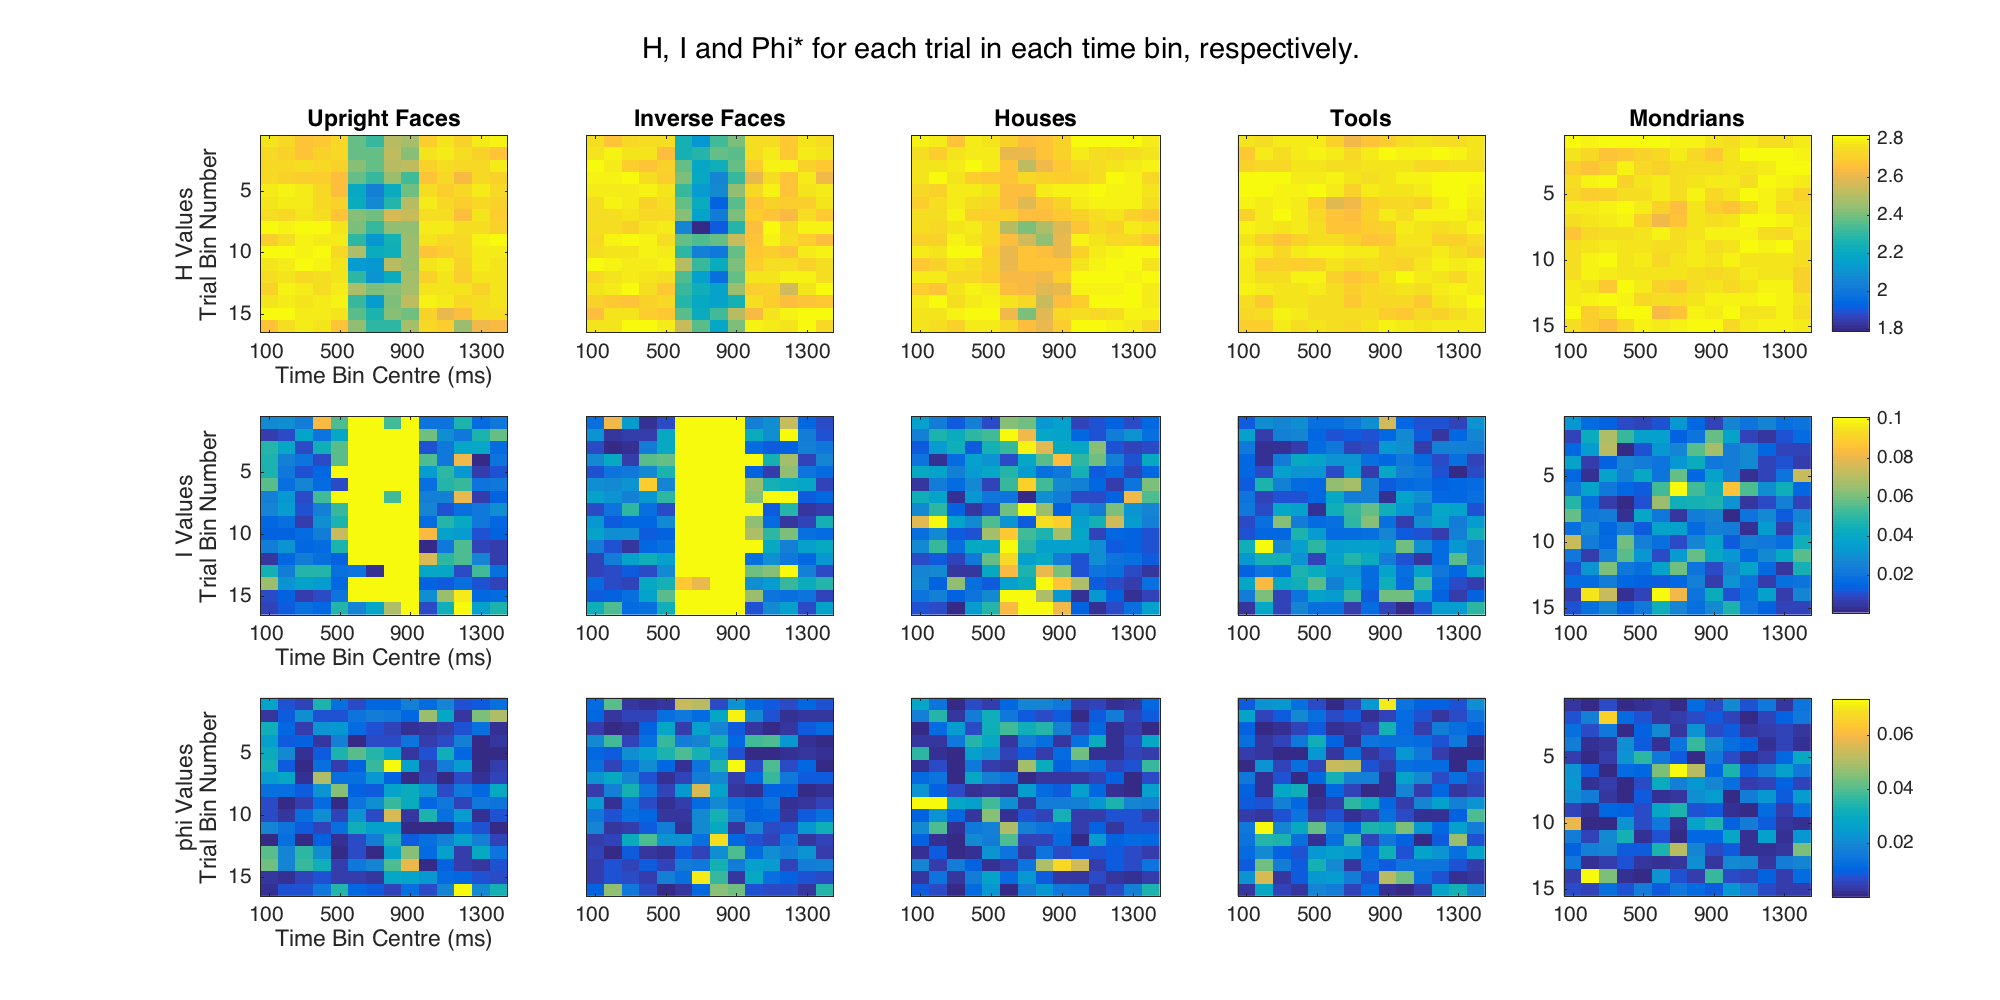

In [23]:
bin_centres = (T/2):(T/2):(size(current_data_chn_1, 2) - T/2);

parameters = {'H', 'I', 'phi'};
classes = {'Upright Faces', 'Inverse Faces', 'Houses', 'Tools', 'Mondrians'};

fig = figure;
for row = 1:3

    parameter = parameters{row};  
    
    % Find minimum and maximum values so colour maps within a row are
    % consistent. Placeholder till I think of a better way to do this.
    param_mins = [];
    param_maxs = [];

    for i = 1:5
        eval(['param_mins = horzcat(param_mins, min(min(processed(i).values_' parameter ')));']);
        eval(['param_maxs = horzcat(param_maxs, max(max(processed(i).values_' parameter ')));']);
    end
    
    bounds = [min(param_mins), min(param_maxs)];
    
    for column = 1:5
    
        position = (row - 1)* 5 + column;
        
        subplot(3, 5, position);     
        
        eval(['plot_data = processed(column).values_' parameter ';']);
        
        imagesc(plot_data);
        caxis manual
        caxis([bounds(1), bounds(2)]);
        
        % Remap bin_centres to actual time
        bin_centre_times = bin_centres / 2.03;
        
        set(gca, 'xtick', 1:4:length(bin_centre_times));
        set(gca, 'xticklabel', bin_centre_times(1:4:end));


        % Check if in top row
        if position <= 5
        
            title(classes{position});
            
        end
        
        % Check if far left plot
        if mod(position, 5) == 1
        
            ylabel({[parameter ' Values'], 'Trial Bin Number'});
            xlabel('Time Bin Centre (ms)');
          
        % Check if far right plot
        elseif mod(position, 5) == 0
            
            colorbar;
            
        else
            set(gca, 'ytick', []);
            
        end
            

    end
end

suptitle('H, I and Phi* for each trial in each time bin, respectively.');

The order of the classes above is Upright Faces, Inverse Faces, Houses, Tools and Mondrians (I believe). 

Hmm - interesting. You can see the stimulus time very easily delineated at the on the upright face, inverse face and house stimuli (sort of) for conditional entropy (H) and mutual information (I). The decrease in H I believe is consistent with a Haun et al's results but the increase in mutual information is not - in fact, I believe Haun et al. found it decreased at the stimulus time. That is rather surprising. 

$\Phi$\*, our main topic of interest, is less clear. It seems that for the upright faces, at roughly time bin centre = 800ms, there is a slight increase not seen in houses, tools or Mondrians for some trials. But it is not entirely clear.

# Visualising Mean $\Phi$\*

Now that we have a trial-by-trial $\Phi$\* plot, let's plot the means over all trials with shaded standard error. We will present the plots in the same way as above but use a line graph instead of a colour map.

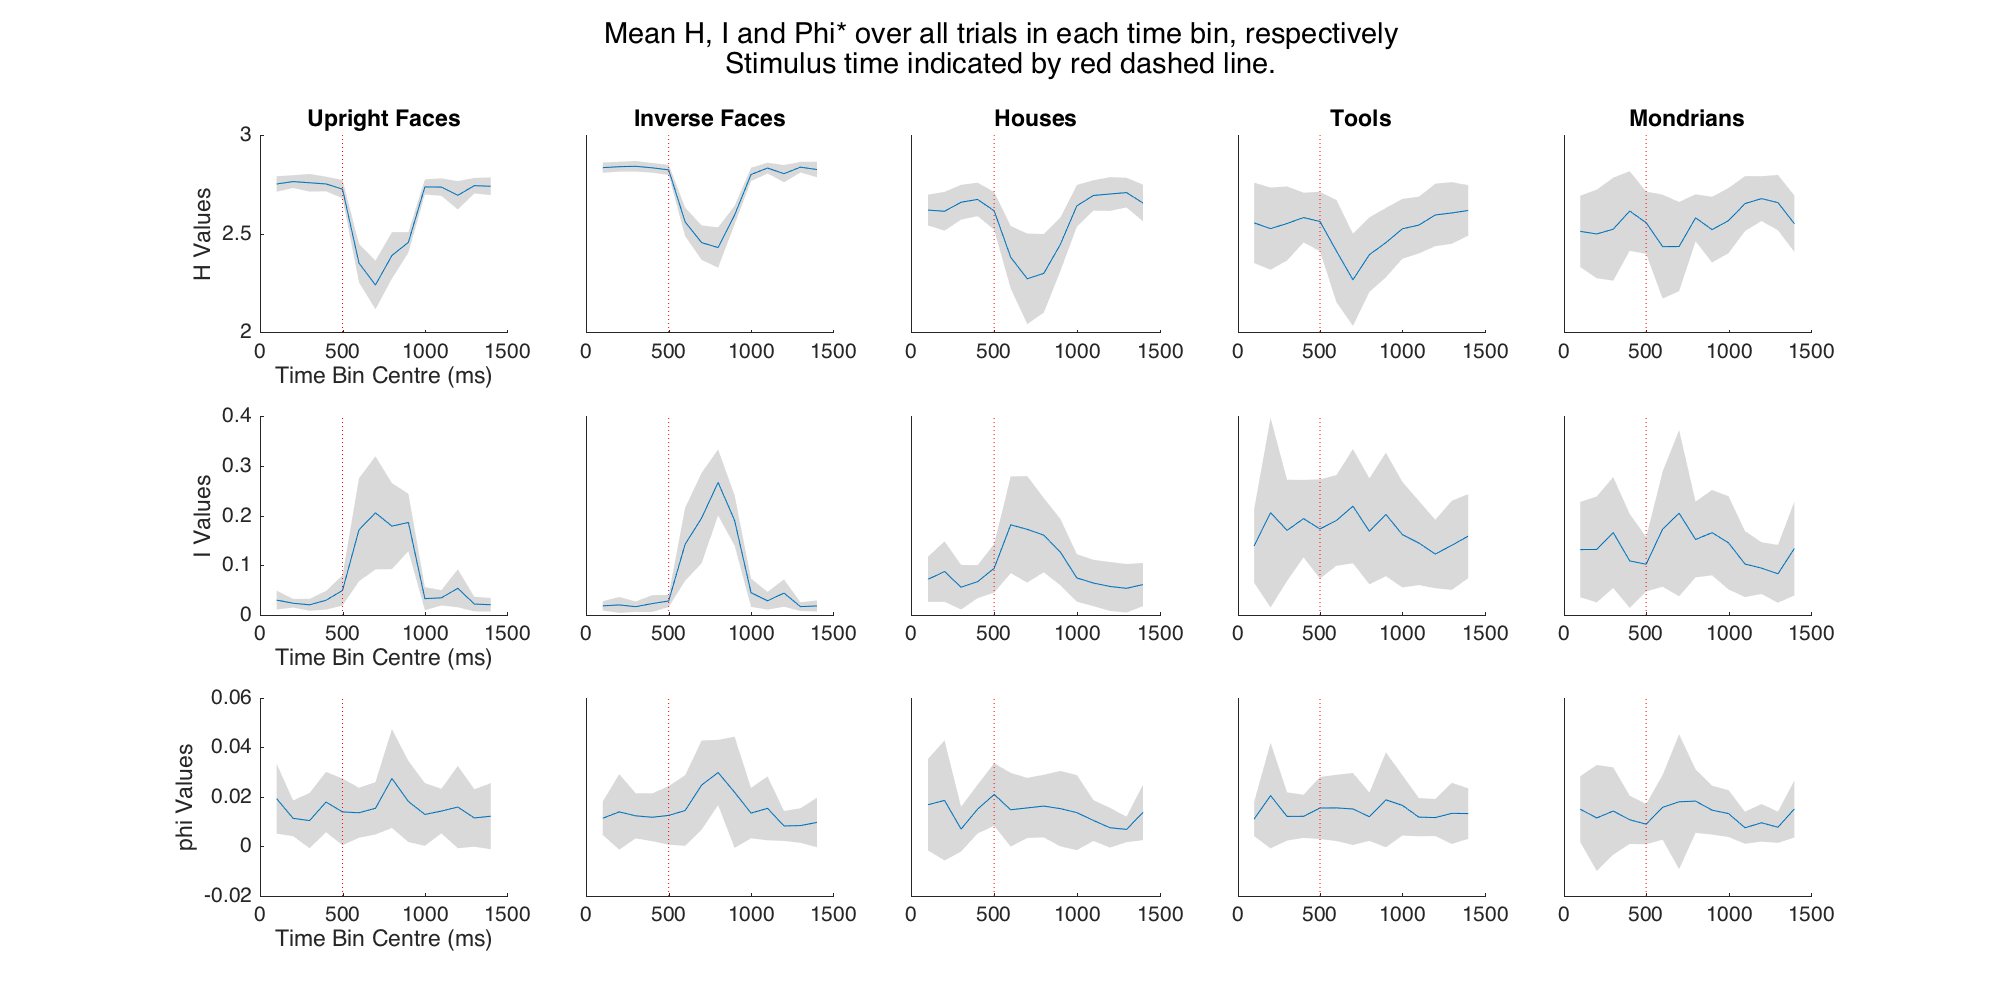

In [28]:
fig_means = figure;

parameters = {'H', 'I', 'phi'};

for row = 1:3
    
    for column = 1:5
        
        position = (row - 1)* 5 + column;
        
        subplot(3, 5, position);
        
        parameter = parameters{row};       
        
        eval(['plot_data = processed(column).values_' parameter ';']);
        
        % Remove complex values
        plot_data(imag(plot_data) ~= 0) = NaN;
        
        plot_means = nanmean(plot_data, 1);
        plot_stderrs = nanstd(plot_data, 1, 1);
        
        % Remap bin_centres to actual times
        bin_centre_times = bin_centres / 2.03;

        patch([bin_centre_times, fliplr(bin_centre_times)], ...
            [plot_means + plot_stderrs, fliplr(plot_means - plot_stderrs)], ...
            [0.85, 0.85, 0.85], ... % colour
            'EdgeColor', 'None');
        hold on
        plot(bin_centre_times, plot_means)
        hold on
        axis manual
        plot([500, 500], [-1, 3], 'r:') % stimulus time
        
        % Check if in top row
        if position <= 5
        
            title(classes{position});
            
        end
        
        % Check if far left plot
        if mod(position, 5) == 1
        
            ylabel([parameter ' Values']);
            xlabel('Time Bin Centre (ms)');
            
        else
            set(gca, 'ytick', []);
            
        end
        

    end
end

suptitle({'Mean H, I and Phi* over all trials in each time bin, respectively', ...
            'Stimulus time indicated by red dashed line.'});

# Appendix

Below is/are functions used in this Jupyter notebook. Because Matlab requires function definitions to be in a separate file, these will not run below; however, they will ensure that at least all the required code is contained in this notebook alone.

## calc_single_trial.m

In [29]:
%load calc_single_trial.m

In [ ]:
function [phi, I, H] = calc_single_trial(current_bin, tau)
%Calculates phi structures for a single trial of ERP value data
    %
    % INPUTS:
    %   current_bin: a channel x sample array of ERP values
    %   tau: the time lag value to distinguish present and past state
    % OUTPUTS:
    %   phi: pair of non-normalised and normalised phi values
    %   I: mutual information 
    %   H: conditional entropy

    % Calculating covariance matrices
    [cov_present, cov_cross] = Cov_comp_sample(current_bin, tau);

    %% Phi calculation
    % We use phi_gauss from the practical_phi toolbox (Oizumi et al 2016) with
    % the assumption that covariance of the past state is the same as
    % covariance of the present state. As we are only using two channels, we
    % undertake the atomic partition by default.
    [phi, ~, ~, ~, I, ~, ~, H] = phi_comp(cov_present, cov_cross);

end